In [4]:
# FOR GETTING VALIDATION DATA WHEN TESTING LEARNED MODEL
%load_ext autoreload
%autoreload
import matplotlib.pyplot as plt
import train
import numpy as np
import tqdm
import glob
import torch
from PIL import Image


import data_utils.dataset as ds
import utils.optimizer_utils as optim_utils
import utils.diffuser_utils as diffuser_utils
from utils.helper_functions import read_config
import os
device = torch.device("cuda:0")

torch.cuda.get_device_name(device)
torch.tensor([1,2,3]).to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


tensor([1, 2, 3], device='cuda:0')

In [5]:
psf_path_rel = "/home/cfoley_waller/defocam/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/11_21/singlepos/psfs_ONAXIS_telecent25um"
test_meas_path_rel = "/home/cfoley_waller/defocam/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/11_21/exp_meas/duckincar"
calib_mat_path_rel = "/home/cfoley_waller/defocam/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/calib_matrix_11_10_2023_2_preprocessed/calibration_matrix_450-810_30chan_stride12_avg12.mat"

#exp params
sim_blur = True
w_init = [0.003, 0.018, 0.04, 0.06, 0.095]
crop_center = [1000, 2000]
crop_size = [768, 768]
patch_size = [768, 768]
ksizes = [7, 21, 45, 55, 65]
exposures = [1 / 662, 1 / 110, 1 / 45, 1 / 30, 1 / 21]
num_ims = len(exposures)

Drawing plot: 100%|██████████| 5/5 [00:00<00:00, 23.72it/s]


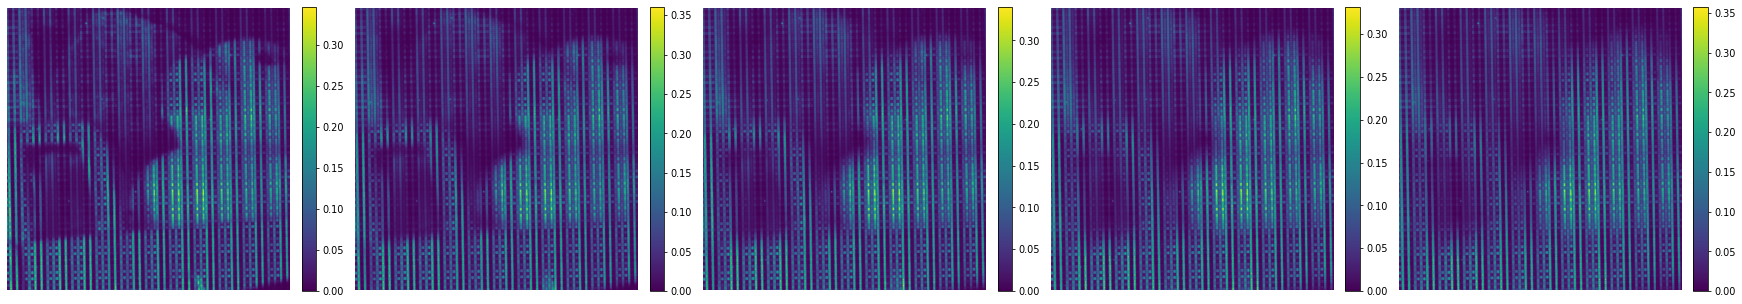

In [9]:
files = sorted(glob.glob(os.path.join(test_meas_path_rel, "*.bmp")))
prep = lambda x: diffuser_utils.preprocess_meas(
    x, 
    center=crop_center,
    crop_size=crop_size[0],
    dim=patch_size[0],
    outlier_std_threshold=3
)
measurements = [prep(np.array(Image.open(x))) for x in tqdm.tqdm(files, "Preprocessing")]

fig, ax = plt.subplots(1, len(measurements), figsize=(5*len(measurements), 9), dpi=70)
for i, meas in tqdm.tqdm(list(enumerate(measurements)), "Drawing plot"):
    img1 = ax[i].imshow(meas)
    fig.colorbar(img1, ax=ax[i], fraction=0.046, pad=0.04)
    ax[i].axis('off')
    ax[i].axis('off')

plt.tight_layout()

In [ ]:
#sim params
image_index = 13
sim_meas = True

base_data_path = os.path.join(defocuscamdata_path, data_path_rel)

In [10]:
### Setup & specify the training config file
config = "/home/cfoley_waller/defocam/defocuscamdata/models/checkpoint_train_11_21_2023_lri_precomputed_real_psfs.yml/2023_11_24_01_58_52/training_config.yml" 
config = read_config(config)

In [12]:
### First check whether simulated measurements from the validation set are reconstructing
config["forward_model_params"]["sim_meas"] = True

model = train.get_model(config, device = device)
print("Loaded model...")

trn, val, tst = ds.get_data(1, (0.7, 0.15, 0.15), config["base_data_path"], patch_size, 1)
loss_function = optim_utils.get_loss_function(
        config["loss_function"]["name"], config["loss_function"]["params"]
    )
print("Loaded data...")

val_loss, test_np, gt_np = train.evaluate(model, val, loss_function, device)
print("Validation loss: ", val_loss)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(np.mean(test_np,0))
ax[1].imshow(np.mean(gt_np, 0))
plt.show()

Loaded model...


ValueError: num_samples should be a positive integer value, but got num_samples=0

cuda:0 _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24268MB, multi_processor_count=82)
cuda:0
Loaded model...


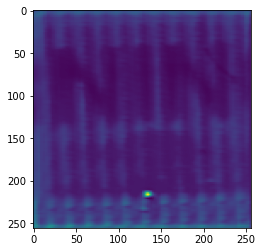

In [12]:
### Then we can try to reconstruct an experimental measurement
config["forward_model_params"]["sim_meas"] = False
config["forward_model_params"]["sim_blur"] = False
config["forward_model_params"]["apply_adjoint"] = True
config["forward_model_params"]["spectral_pad_output"] = True
model = train.get_model(config, device = device)
print("Loaded model...")

meas_stack_tensor = meas_stack.unsqueeze(0).to(device).float()
out = model(meas_stack_tensor)
plt.imshow(np.mean(out.detach().cpu().numpy()[0], 0))
plt.show()